In [1]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import Model
import tensorflow.keras.backend as K
from keras.layers import Conv2D,MaxPool2D,concatenate,AveragePooling2D,Add,GlobalAveragePooling2D,Flatten,ZeroPadding2D,BatchNormalization,Dense,ZeroPadding2D,Activation,ReLU,Input,DepthwiseConv2D
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from keras.preprocessing import image
gpus=tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [2]:
#Importing Data
train_dir=r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Dataset\Train'
test_dir=r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Dataset\Test'
valid_dir=r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Dataset\Valid'

In [3]:
#Rescaling and augmentation of data
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224,224,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
],name="data_augmentation")

In [4]:
IMG_SIZE=(224,224)
BATCH_SIZE=5
training_set=tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode = 'categorical',
    shuffle=False
)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = valid_dir,
    image_size = IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode = 'categorical',
)
class_names=validation_set.class_names

Found 1376 files belonging to 5 classes.
Found 172 files belonging to 5 classes.
Found 172 files belonging to 5 classes.


In [5]:
def inverted_residual_block(inputs, filters, expansion, stride, kernel_size=3):
    """
    Constructs an inverted residual block with bottleneck.

    Arguments:
    - inputs: Input tensor.
    - filters: Number of filters for the pointwise convolution.
    - expansion: Expansion factor for the inner bottleneck.
    - stride: Stride of the depthwise convolution.
    - kernel_size: Kernel size of the depthwise convolution.

    Returns:
    - Output tensor for the block.
    """

    # Pointwise convolution expanding dimensions
    x = Conv2D(filters * expansion, (1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Pointwise convolution squeezing back dimensions
    x = Conv2D(filters, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Adding the residual connection when possible
    if stride == 1 and inputs.shape[-1] == filters:
        x = Add()([x, inputs])

    return x

def MobileNetV2(input_shape=(224, 224, 3), classes=5):
    """
    Constructs the MobileNetV2 architecture.

    Arguments:
    - input_shape: Shape of the input tensor.
    - num_classes: Number of classes for the classification task.

    Returns:
    - Model object.
    """

    inputs = Input(shape=input_shape)

    # Initial convolution layer with larger filter size and stride
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Sequence of inverted residual blocks
    # The configurations of filters, expansion factors, strides, and kernel sizes
    # are based on the MobileNetV2 paper and its typical implementations
    x = inverted_residual_block(x, 16, 1, 1, 3)
    x = inverted_residual_block(x, 24, 6, 2, 3)
    x = inverted_residual_block(x, 24, 6, 1, 3)
    x = inverted_residual_block(x, 32, 6, 2, 3)
    x = inverted_residual_block(x, 32, 6, 1, 3)
    x = inverted_residual_block(x, 32, 6, 1, 3)
    x = inverted_residual_block(x, 64, 6, 2, 3)
    x = inverted_residual_block(x, 64, 6, 1, 3)
    x = inverted_residual_block(x, 64, 6, 1, 5)
    x = inverted_residual_block(x, 64, 6, 1, 5)
    x = inverted_residual_block(x, 96, 6, 1, 5)
    x = inverted_residual_block(x, 96, 6, 1, 3)
    x = inverted_residual_block(x, 96, 6, 1, 3)
    x = inverted_residual_block(x, 160, 6, 2, 3)
    x = inverted_residual_block(x, 160, 6, 1, 5)
    x = inverted_residual_block(x, 160, 6, 1, 5)
    x = inverted_residual_block(x, 320, 6, 1, 3)

    # Final pointwise convolution layer
    x = Conv2D(1280, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Global pooling and fully connected layer for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(classes, activation='softmax')(x)

    return Model(inputs=inputs,outputs=outputs)



In [6]:
model=MobileNetV2(input_shape=(224,224,3),classes=5)

In [7]:
from keras.callbacks import ModelCheckpoint
#Checkpoint to save the best model per epoch
model_path=r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Models\MobileNetV2_Checkpoints\MobileNet{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpoint=ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_7 (Conv2D)              (None, 56, 56, 192)  4800        ['add[0][0]']                    
                                                                                                  
 batch_normalization_10 (BatchN  (None, 56, 56, 192)  768        ['conv2d_7[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 re_lu_7 (ReLU)                 (None, 56, 56, 192)  0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 depthwise_conv2d_3 (DepthwiseC  (None, 28, 28, 192)  1920       ['re_lu_7[0][0]']                
 onv2D)                                                                                           
          

                                                                                                  
 batch_normalization_21 (BatchN  (None, 14, 14, 64)  256         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_15 (Conv2D)             (None, 14, 14, 384)  24960       ['batch_normalization_21[0][0]'] 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 14, 14, 384)  1536       ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_15 (ReLU)                (None, 14, 14, 384)  0           ['batch_normalization_22[0][0]'] 
          

 batch_normalization_32 (BatchN  (None, 14, 14, 576)  2304       ['depthwise_conv2d_10[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_22 (ReLU)                (None, 14, 14, 576)  0           ['batch_normalization_32[0][0]'] 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 14, 14, 96)   55392       ['re_lu_22[0][0]']               
                                                                                                  
 batch_normalization_33 (BatchN  (None, 14, 14, 96)  384         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_23

 depthwise_conv2d_14 (Depthwise  (None, 7, 7, 960)   24960       ['re_lu_29[0][0]']               
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_44 (BatchN  (None, 7, 7, 960)   3840        ['depthwise_conv2d_14[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_30 (ReLU)                (None, 7, 7, 960)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 7, 7, 160)    153760      ['re_lu_30[0][0]']               
                                                                                                  
 batch_nor

In [9]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
#Training the model
history=model.fit(
    training_set,
    epochs=200,
    validation_data=validation_set,
    batch_size=5,
    callbacks=[checkpoint],
)

Epoch 1/200
276/276 [==============================] - ETA: 0s - loss: 1.3019 - accuracy: 0.4847
Epoch 1: val_loss improved from inf to 1.67381, saving model to C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Models\MobileNetV2_Checkpoints\MobileNet01-0.3488.hdf5
276/276 [==============================] - 100s 253ms/step - loss: 1.3019 - accuracy: 0.4847 - val_loss: 1.6738 - val_accuracy: 0.3488
Epoch 2/200
276/276 [==============================] - ETA: 0s - loss: 1.0053 - accuracy: 0.5858
Epoch 2: val_loss did not improve from 1.67381
276/276 [==============================] - 64s 228ms/step - loss: 1.0053 - accuracy: 0.5858 - val_loss: 2.0244 - val_accuracy: 0.3488
Epoch 3/200
275/276 [============================>.] - ETA: 0s - loss: 0.9319 - accuracy: 0.6364
Epoch 3: val_loss did not improve from 1.67381
276/276 [==============================] - 76s 273ms/step - loss: 0.9348 - accuracy: 0.6359 - val_loss: 2.4056 - val_accuracy: 0.4244
Epoch 4/200
276/276 [=======================

Epoch 26/200
276/276 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9331
Epoch 26: val_loss improved from 0.42447 to 0.39421, saving model to C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Models\MobileNetV2_Checkpoints\MobileNet26-0.9070.hdf5
276/276 [==============================] - 37s 128ms/step - loss: 0.1957 - accuracy: 0.9331 - val_loss: 0.3942 - val_accuracy: 0.9070
Epoch 27/200
275/276 [============================>.] - ETA: 0s - loss: 0.2002 - accuracy: 0.9375
Epoch 27: val_loss did not improve from 0.39421
276/276 [==============================] - 36s 125ms/step - loss: 0.2005 - accuracy: 0.9375 - val_loss: 1.6773 - val_accuracy: 0.6453
Epoch 28/200
275/276 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9680
Epoch 28: val_loss improved from 0.39421 to 0.38159, saving model to C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Models\MobileNetV2_Checkpoints\MobileNet28-0.8953.hdf5
276/276 [==============================] - 3

Epoch 53/200
276/276 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9578
Epoch 53: val_loss did not improve from 0.13931
276/276 [==============================] - 36s 126ms/step - loss: 0.1642 - accuracy: 0.9578 - val_loss: 0.5547 - val_accuracy: 0.8430
Epoch 54/200
276/276 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9920
Epoch 54: val_loss did not improve from 0.13931
276/276 [==============================] - 36s 125ms/step - loss: 0.0299 - accuracy: 0.9920 - val_loss: 0.2178 - val_accuracy: 0.9477
Epoch 55/200
276/276 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9876
Epoch 55: val_loss did not improve from 0.13931
276/276 [==============================] - 36s 126ms/step - loss: 0.0489 - accuracy: 0.9876 - val_loss: 0.2332 - val_accuracy: 0.9477
Epoch 56/200
275/276 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9716
Epoch 56: val_loss did not improve from 0.13931
276/276 [=====

Epoch 82/200
276/276 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9869
Epoch 82: val_loss did not improve from 0.11801
276/276 [==============================] - 36s 125ms/step - loss: 0.0501 - accuracy: 0.9869 - val_loss: 0.3339 - val_accuracy: 0.9360
Epoch 83/200
275/276 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9709
Epoch 83: val_loss did not improve from 0.11801
276/276 [==============================] - 36s 125ms/step - loss: 0.1050 - accuracy: 0.9709 - val_loss: 1.3468 - val_accuracy: 0.8081
Epoch 84/200
276/276 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9767
Epoch 84: val_loss did not improve from 0.11801
276/276 [==============================] - 36s 128ms/step - loss: 0.0732 - accuracy: 0.9767 - val_loss: 0.2908 - val_accuracy: 0.9360
Epoch 85/200
276/276 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9993
Epoch 85: val_loss did not improve from 0.11801
276/276 [=====

Epoch 111/200
276/276 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9985
Epoch 111: val_loss did not improve from 0.10895
276/276 [==============================] - 36s 126ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.1364 - val_accuracy: 0.9709
Epoch 112/200
275/276 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9782
Epoch 112: val_loss did not improve from 0.10895
276/276 [==============================] - 36s 125ms/step - loss: 0.0872 - accuracy: 0.9782 - val_loss: 0.4604 - val_accuracy: 0.9244
Epoch 113/200
275/276 [============================>.] - ETA: 0s - loss: 0.0642 - accuracy: 0.9796
Epoch 113: val_loss did not improve from 0.10895
276/276 [==============================] - 36s 126ms/step - loss: 0.0642 - accuracy: 0.9797 - val_loss: 0.3254 - val_accuracy: 0.9186
Epoch 114/200
275/276 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9978
Epoch 114: val_loss did not improve from 0.10895
276/27

276/276 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9942
Epoch 140: val_loss did not improve from 0.10895
276/276 [==============================] - 36s 125ms/step - loss: 0.0193 - accuracy: 0.9942 - val_loss: 0.1158 - val_accuracy: 0.9709
Epoch 141/200
275/276 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 141: val_loss did not improve from 0.10895
276/276 [==============================] - 36s 125ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1370 - val_accuracy: 0.9709
Epoch 142/200
275/276 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9985
Epoch 142: val_loss did not improve from 0.10895
276/276 [==============================] - 35s 125ms/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 0.1387 - val_accuracy: 0.9593
Epoch 143/200
275/276 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9891
Epoch 143: val_loss did not improve from 0.10895
276/276 [===========

275/276 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9956
Epoch 169: val_loss did not improve from 0.10895
276/276 [==============================] - 35s 124ms/step - loss: 0.0106 - accuracy: 0.9956 - val_loss: 0.4059 - val_accuracy: 0.9244
Epoch 170/200
275/276 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9985
Epoch 170: val_loss did not improve from 0.10895
276/276 [==============================] - 35s 124ms/step - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.1164 - val_accuracy: 0.9593
Epoch 171/200
275/276 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9942
Epoch 171: val_loss did not improve from 0.10895
276/276 [==============================] - 36s 125ms/step - loss: 0.0244 - accuracy: 0.9942 - val_loss: 0.2145 - val_accuracy: 0.9419
Epoch 172/200
275/276 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9971
Epoch 172: val_loss did not improve from 0.10895
276/276 [===========

276/276 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9956
Epoch 198: val_loss did not improve from 0.10895
276/276 [==============================] - 36s 125ms/step - loss: 0.0175 - accuracy: 0.9956 - val_loss: 0.2697 - val_accuracy: 0.9535
Epoch 199/200
276/276 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9993    
Epoch 199: val_loss did not improve from 0.10895
276/276 [==============================] - 36s 125ms/step - loss: 0.0063 - accuracy: 0.9993 - val_loss: 0.2797 - val_accuracy: 0.9477
Epoch 200/200
275/276 [============================>.] - ETA: 0s - loss: 0.0446 - accuracy: 0.9876
Epoch 200: val_loss did not improve from 0.10895
276/276 [==============================] - 36s 125ms/step - loss: 0.0446 - accuracy: 0.9876 - val_loss: 0.2429 - val_accuracy: 0.9535


In [11]:
from keras.models import Model,load_model
model=load_model(r"C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Models\MobileNetV2_Checkpoints\MobileNet102-0.9767.hdf5")

In [12]:
import numpy as np
ar=np.empty(0)
for im,y in test_set:
    ar=np.append(ar,y)
yt=np.zeros((172,5))
count=0
for i in range(0,172):
    for j in range(5):
        yt[i][j]=ar[count]
        count+=1
yt=tf.convert_to_tensor(yt,dtype=tf.float32)
print(yt)

tf.Tensor(
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]

In [13]:
yp=model.predict(test_set)
arr=np.zeros(yp.shape)
for i in range(yp.shape[0]):
    for j in range(yp.shape[1]):
        c=yp[i].argmax()
        arr[i][c]=1
yp=arr
print(yp)

35/35 [==============================] - 20s 480ms/step
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 

In [14]:
accuracy=accuracy_score(yt,yp)
print('Accuracy=',accuracy)
precision=precision_score(yt,yp,average=None)
print('Precision=',precision[precision.argmax()])
recall=recall_score(yt,yp,average=None)
print('Recall=',recall[recall.argmax()])
f1=f1_score(yt,yp,average=None)
print('F1 Score=',f1[f1.argmax()])

Accuracy= 0.9476744186046512
Precision= 1.0
Recall= 1.0
F1 Score= 0.9836065573770492


In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

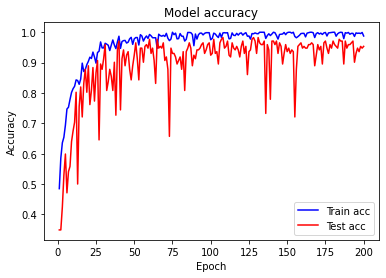

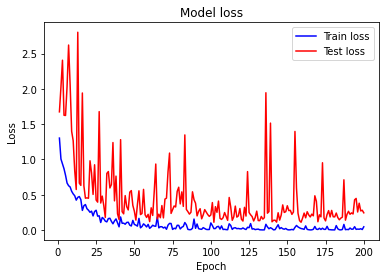

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Train acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
import numpy as np
from keras.preprocessing import image
test_image=tf.keras.utils.load_img(r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Images for checking\img.jpg',target_size=(224,224))
test_image=tf.keras.utils.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
result=result.flatten()
print(result)
print(class_names)
index=result.argmax()
confidence=result[index]*100;
pred_class=class_names[index]
if pred_class!='Groundnut__Healthy':
    print(f'The disease of the given groundnut leaf is {pred_class} predicted with {confidence} % confidence')
else:
    print(f'The groundnut leaf is healthy predicted with {confidence} % confidence')

1/1 [==============================] - 1s 1s/step
[1.7456063e-04 9.9967182e-01 1.5333116e-04 1.4373294e-08 1.9984185e-07]
['Groundnut__Alternaria__Leafspot', 'Groundnut__Early__Late__Leafspot', 'Groundnut__Healthy', 'Groundnut__Rosette', 'Groundnut__Rust']
The disease of the given groundnut leaf is Groundnut__Early__Late__Leafspot predicted with 99.96718168258667 % confidence
